In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import keras
from pathlib import Path
from shutil import copyfile
import tensorflow as tf
import matplotlib.pyplot as plt
from natsort import natsorted
from tqdm import tqdm
from PIL import Image

from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, GlobalAveragePooling2D, Activation, Input, Flatten
from tensorflow.keras.layers import MaxPooling2D, Dropout

Применю сначала предобработку ImageDataGenerator + предобученная модель из keras

In [3]:
# Conf
path_dataset = r'C:\ml\db\OCR_DOC\dataset_fpp_split\train'
img_widht = 224
img_height = 224
channel = 3
batch_size = 32
epoch = 15

In [4]:
# initialize ImageDataGenerator
data_gen = ImageDataGenerator(
    rescale = 1. / 255,
    zoom_range = 0.1,
    validation_split = 0.2
)

In [5]:
train_generator = data_gen.flow_from_directory(
    path_dataset,
    color_mode='rgb',
    target_size=(img_widht, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training'
)

val_generator = data_gen.flow_from_directory(
    path_dataset,
    color_mode = 'rgb',
    target_size = (img_widht, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 6012 images belonging to 5 classes.
Found 1499 images belonging to 5 classes.


In [6]:
print(train_generator.image_shape)
class_map = list(train_generator.class_indices)
print(class_map)


(224, 224, 3)
['0_norm', '1_left', '2_right', '3_down', '4_not_pg']


In [7]:
img, label = next(iter(val_generator))
print(img.shape, label)

(32, 224, 224, 3) [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


visual data

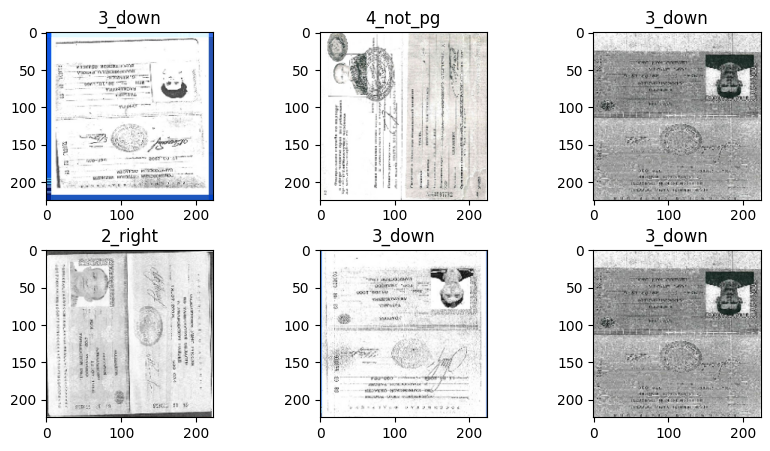

In [8]:
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    n = np.random.randint(img.shape[0])
    plt.imshow(img[n], cmap='gray')
    plt.title(class_map[np.argmax(label[n])], fontsize = 12)
plt.subplots_adjust(wspace=0.2, hspace=0.3)

Define callback

In [9]:
sv_mod = ModelCheckpoint(
    filepath = r'C:\ml\Codes\RECOG_DOCS\CALLBACKS\turn_page_psp\xception\pretr_xception_{epoch:02d}-val_acc-{val_categorical_accuracy:.4f}_val_loss-{val_loss:.4f}.hdf5',
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-10)

ea_stop = EarlyStopping(monitor = 'val_categorical_accuracy',
                        patience = 20)

Pretrained Model from keral.applications Xception

In [9]:
print(tf.keras.applications)

<module 'keras.api._v2.keras.applications' from 'c:\\Users\\ml_srv\\AppData\\Local\\anaconda3\\envs\\env_new\\lib\\site-packages\\keras\\api\\_v2\\keras\\applications\\__init__.py'>


In [12]:
def create_model(freez_batchNorm_only = False):
    base_model = tf.keras.applications.xception.Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    x = base_model.output
    global_average = GlobalAveragePooling2D(name='Clobal_layer')(x) # None, 1024
    drop = Dropout(0.3, name='Dropout_layer')(global_average)
    dense = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(drop)
    batchNorm = BatchNormalization()(dense)
    out = Dense(5, activation='softmax')(batchNorm)

    model = Model(inputs=base_model.input, outputs = out)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adam(learning_rate=0.0001),
                  metrics = ['categorical_accuracy'])
    
    if freez_batchNorm_only == False:
        base_model.trainable = False # замораживаю предобученную модель полностью
    elif freez_batchNorm_only == True:
        for layer in base_model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalizatioin):
                layer.trainable = False
            else:
                layer.trainable = True

    return model

xception_model = create_model()
xception_model.summary()
    



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [43]:
type(xception_model)

keras.engine.functional.Functional

Training model

Epoch 1/15
187/187 [==============================] - 73s 348ms/step - loss: 0.1845 - categorical_accuracy: 0.9398 - val_loss: 0.1435 - val_categorical_accuracy: 0.9735 - lr: 1.0000e-04
Epoch 2/15
187/187 [==============================] - 64s 339ms/step - loss: 0.0257 - categorical_accuracy: 0.9935 - val_loss: 0.0138 - val_categorical_accuracy: 0.9986 - lr: 1.0000e-04
Epoch 3/15
187/187 [==============================] - 63s 337ms/step - loss: 0.0169 - categorical_accuracy: 0.9953 - val_loss: 0.0045 - val_categorical_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 4/15
187/187 [==============================] - 63s 337ms/step - loss: 0.0089 - categorical_accuracy: 0.9982 - val_loss: 0.0066 - val_categorical_accuracy: 0.9986 - lr: 1.0000e-04
Epoch 5/15
187/187 [==============================] - 63s 336ms/step - loss: 0.0041 - categorical_accuracy: 0.9990 - val_loss: 0.0143 - val_categorical_accuracy: 0.9946 - lr: 1.0000e-04
Epoch 6/15
187/187 [==============================] - ETA: 0s - loss: 

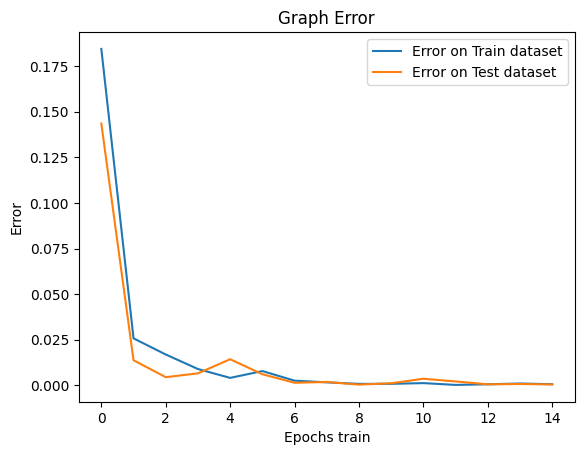

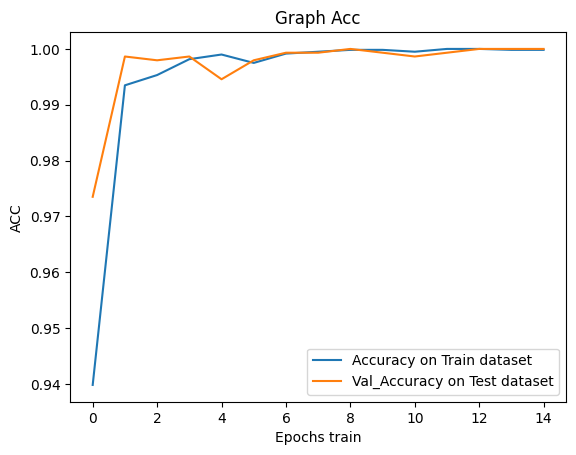

In [11]:
history = xception_model.fit(train_generator,
                             steps_per_epoch = train_generator.samples // batch_size,
                             epochs = epoch,
                             validation_data = val_generator,
                             validation_steps = val_generator.samples // batch_size,
                             callbacks = [sv_mod, lr_reduction, ea_stop],
                             verbose = 1
)

#Отображение
plt.plot(history.history['loss'],label = 'Error on Train dataset')
plt.plot(history.history['val_loss'], label = 'Error on Test dataset')
plt.xlabel('Epochs train')
plt.ylabel('Error')
plt.legend()
plt.title('Graph Error')
plt.show()

plt.plot(history.history['categorical_accuracy'],label = 'Accuracy on Train dataset')
plt.plot(history.history['val_categorical_accuracy'], label = 'Val_Accuracy on Test dataset')
plt.xlabel('Epochs train')
plt.ylabel('ACC')
plt.legend()
plt.title('Graph Acc')
plt.show()

Inference

In [2]:
def preprocess_img(path_img, shape = (224, 224)):
    img = image.load_img(path_img, target_size = shape)
    img = image.img_to_array(img)
    img = np.array(img) / 255
    img = np.expand_dims(img, axis=0)
    return img

In [41]:
def infer_test(path):
    """
        path = pathlib.Path
    """
    lbl_pred = []
    correct = 0
    test_imgs = sorted(list(Path(path).rglob('*.jpg')))
    labels = [file.parent.name for file in test_imgs]
    assert len(test_imgs) == len(labels), 'not equal labels with test_imgs'
    for i in tqdm(range(len(test_imgs))):
        img = preprocess_img(test_imgs[i])
        correct += np.sum(class_map[np.argmax(xception_model(img))] == labels[i])
    val_acc = correct / len(test_imgs)
    print(f'Длина тестовой базы - {len(test_imgs)}, процент правильных ответов - {val_acc}')
    

Проверка на тестовой базе которая не была в обучении

In [42]:
path_test_imgs = r'C:\ml\db\OCR_DOC\dataset_fpp_split\test'
infer_test(path_test_imgs)

100%|██████████| 406/406 [00:16<00:00, 24.67it/s]

Длина тестовой базы - 406, процент правильных ответов - 0.9975369458128078


In [3]:
path_img = r'C:\ml\db\OCR_DOC\dataset_fpp_split\test\2_right\45_crop_r.jpg'
img = preprocess_img(path_img)
img.shape

(1, 224, 224, 3)

In [17]:
pred = xception_model(img)
cl = class_map[np.argmax(pred)]
print(cl)

2_right


Автоматический переворот фото

In [10]:
# create model
def create_model(freez_batchNorm_only = False):
    base_model = tf.keras.applications.xception.Xception(
        weights = 'imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    x = base_model.output
    global_average = GlobalAveragePooling2D(name='Clobal_layer')(x) # None, 1024
    drop = Dropout(0.3, name='Dropout_layer')(global_average)
    dense = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(drop)
    batchNorm = BatchNormalization()(dense)
    out = Dense(5, activation='softmax')(batchNorm)

    model = Model(inputs=base_model.input, outputs = out)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = Adam(learning_rate=0.0001),
                  metrics = ['categorical_accuracy'])
    
    if freez_batchNorm_only == False:
        base_model.trainable = False # замораживаю предобученную модель полностью
    elif freez_batchNorm_only == True:
        for layer in base_model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalizatioin):
                layer.trainable = False
            else:
                layer.trainable = True

    return model

def preprocess_img(path_img, shape = (224, 224)):
    img = image.load_img(path_img, target_size = shape)
    img = image.img_to_array(img)
    img = np.array(img) / 255
    img = np.expand_dims(img, axis=0)
    return img

# функция получения класса с предикта
def get_class(model, img_arr):
    class_map = ['0_norm', '1_left', '2_right', '3_down', '4_not_pg']
    out = class_map[np.argmax(model(img_arr))]
    return out
    
# функция на полученных данных поворот фото
# def correct_photo(img_arr, class_turn):
#     img_arr = (img_arr.squeeze() * 255).astype(np.uint8)
#     # print(' - ', img_arr.shape, class_turn)
#     image = Image.fromarray(img_arr)
#     if class_turn == '1_left':
#         image = image.rotate(-90, expand=True)
#     elif class_turn == '2_right':
#         image = image.rotate(+90, expand=True)
#     elif class_turn == '3_down':
#         image = image.rotate(180, expand=True)
#     elif class_turn == '4_not_pg':
#         return None
#     else:
#         image = image
#     return image

def correct_photo(path_img, class_turn):
    
    image = Image.open(path_img)
    if class_turn == '1_left':
        image = image.rotate(-90, expand=True)
    elif class_turn == '2_right':
        image = image.rotate(+90, expand=True)
    elif class_turn == '3_down':
        image = image.rotate(180, expand=True)
    elif class_turn == '4_not_pg':
        return None
    else:
        image = image
    return image


In [14]:
# test function

# new_path_img = r'C:\ml\db\OCR_DOC\dataset_fpp\2_right\11_crop.jpg'
# imgt = preprocess_img(new_path_img)
# cl_turn = get_class(xcept_model, imgt)
# imvvg = correct_photo(new_path_img, cl_turn)
# imvvg.save('imvvg.jpg')
# print(np.array(imvvg).shape)


(666, 488, 3)


In [13]:
def load_model(path_weight):
    model = create_model()
    model.load_weights(path_weight)
    assert isinstance(model, keras.engine.functional.Functional), 'Not load model('
    return model

path_ = r'C:\ml\Codes\RECOG_DOCS\CALLBACKS\turn_page_psp\xception\pretr_xception_09-val_acc-1.0000_val_loss-0.0004.hdf5'
xcept_model = load_model(path_)
xcept_model.summary()
    

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [15]:
def create_assert_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        assert os.path.isdir(path), 'Not create dir...'
        return path
    else:
        return path


In [18]:
def turn_page(path_img, path_save_turn_img, model): 
    name = path_img.name   
    img_arr = preprocess_img(str(path_img)) # preprocess img in model
    cl_pred = get_class(model, img_arr)  # compute class turn photo
    image = correct_photo(path_img, cl_pred) # rotation photo
    if image is not None: # вот здесь переделать для подачи в следующий этап !!!!!
        image.save(f'{path_save_turn_img}\{name}')
    else:
        copyfile(str(path_img), f'{path_save_turn_img}\{name}') #  и здесь это ответвление только для теста, переделать!!!!!


In [19]:
path_all_test_files = r'C:\ml\db\OCR_DOC\dataset_fpp_split\test'
path_save_test_img = r'C:\ml\db\OCR_DOC\saves_first_page_psp'
all_files = list(Path(path_all_test_files).rglob('*.jpg'))
print(len(all_files))
for file in tqdm(all_files):
    folder_name = file.parent.name
    path_to_save_test = os.path.join(path_save_test_img, folder_name)
    path_save = create_assert_dir(path_to_save_test)
    turn_page(file, path_save, xcept_model)

all_test_files = list(Path(path_save_test_img).rglob('*.jpg'))
print(len(all_test_files))    

406


100%|██████████| 406/406 [00:17<00:00, 23.07it/s]

406
